In [102]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
     



def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def apply_smoothing(image, kernel_size=13):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)


def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
        
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    
    # first, define the polygon by vertices    
    bottom_left  = [cols*0.01, rows*0.99]
    top_left     = [cols*0.01, rows*0.5]
    bottom_right = [cols*0.9, rows*0.99]
    top_right    = [cols*0.9, rows*0.5] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

def get_slope_intercept_longest(lines):
    ''' Return slope and intercept of the longest line observed'''
    intercepts_slopes = [] # (slope, intercept)     
    lengths   = [] # (slope, intercept)
    #longest_line = []
    
    for line in lines:
        type(line)
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (float(y2)-float(y1))/(float(x2)-float(x1))
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
             
            intercepts_slopes.append((  slope, intercept))
            lengths.append(( length))

    # return only the longest line 
    #longest_line.append( intercepts_slopes[lengths.index(max(lengths))]   )
            
    #return longest_line #(slope, intercept) 
    return intercepts_slopes[lengths.index(max(lengths))] 

def make_line_points(image, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    print(line)
    slope, intercept = line[0]
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return([x1, y1, x2, y2])


def make_line_points(image, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    slope, intercept = line  
    x1 = int(0) # start far left
    x2 = int(image.shape[1]) # end far left
    y1 = int(intercept)
    y2 = int(intercept + slope*(x2-x1))
   
    # make sure everything is integer as cv2.line requires it
    return([x1, y1, x2, y2])


def draw_line(image, line, color=[255, 0, 0], thickness=2, make_copy=True):
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    x1,y1,x2,y2 = line
    cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

def select_aoi(image,line_slope_inter):
    """  It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # get slope and intercept 
    slope, intercept = line_slope_inter
    
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    
    bottom_left  = [cols*0, rows]
    top_left     = [cols*0, intercept-95]
    bottom_right = [cols*1, rows]
    top_right    = [cols*1, intercept-95+slope*cols] 
    #print(bottom_left,top_left,bottom_right,top_right)
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)


def select_yellow(image):
    converted = convert_hsv(image)
    # yellow color mask
    #                  Hue  Sat  Light
    lower = np.uint8([ 5,  50, 100])  
    upper = np.uint8([ 25, 160, 160])     
 
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = yellow_mask 
    return cv2.bitwise_and(image, image, mask = mask)
test_images = [plt.imread(path) for path in glob.glob('/home/mmann1123/Dropbox/Apps/PiCameraLogger/14_03_2018/*.jpg')]

    

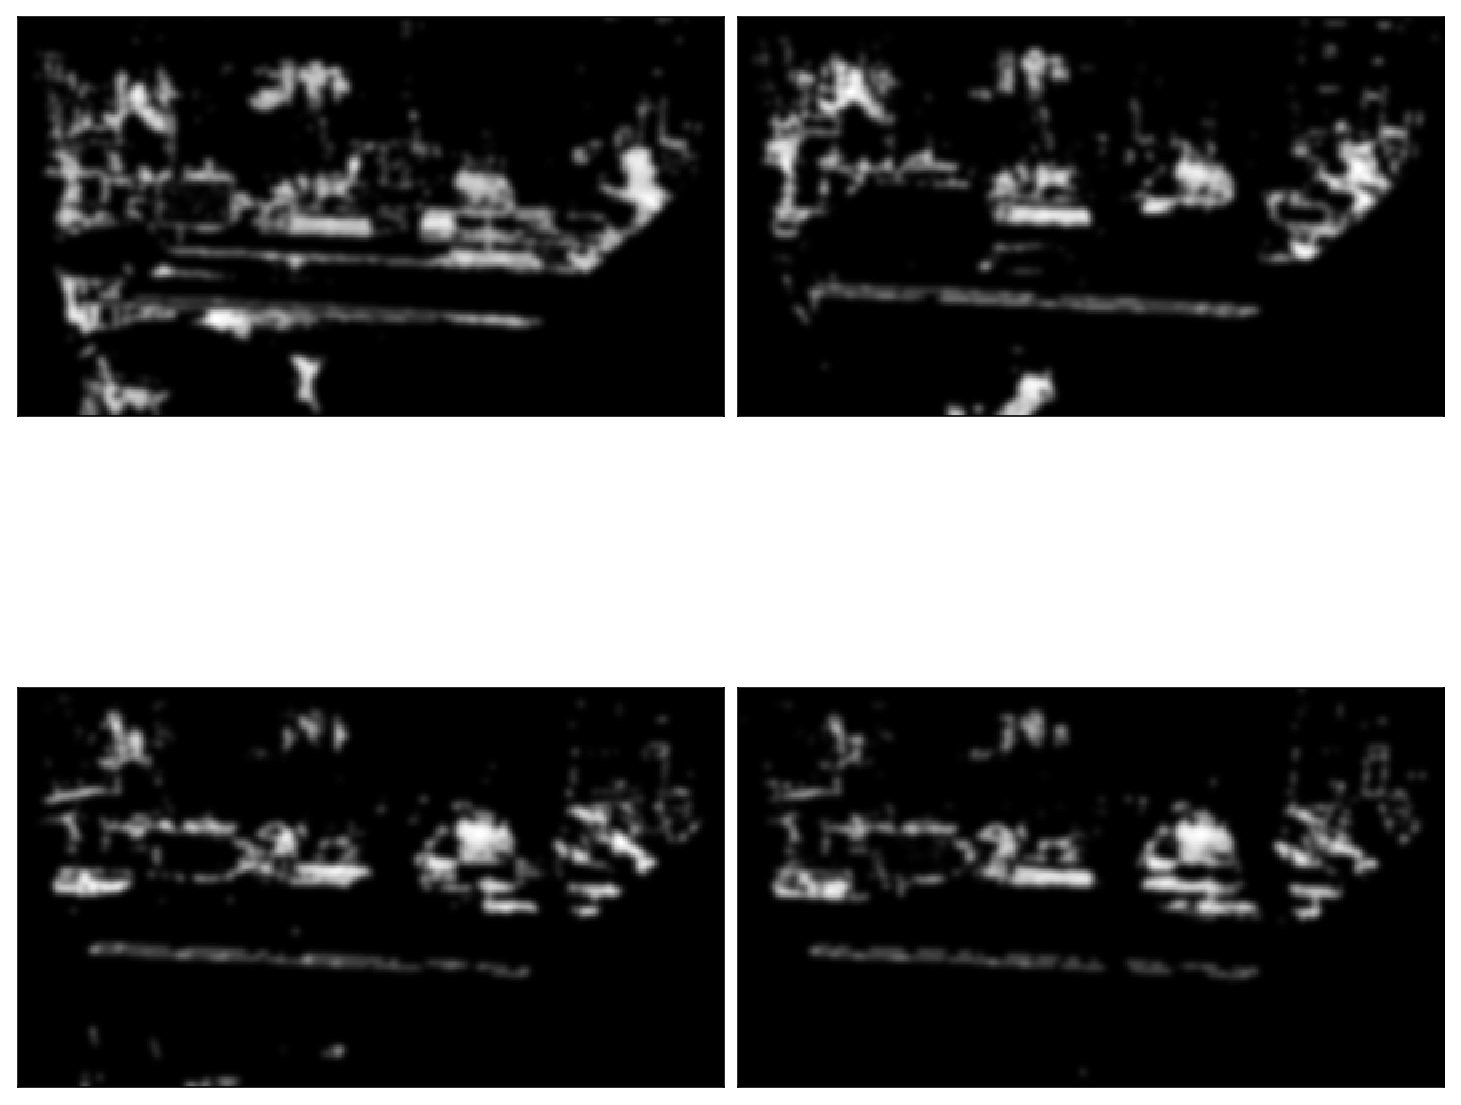

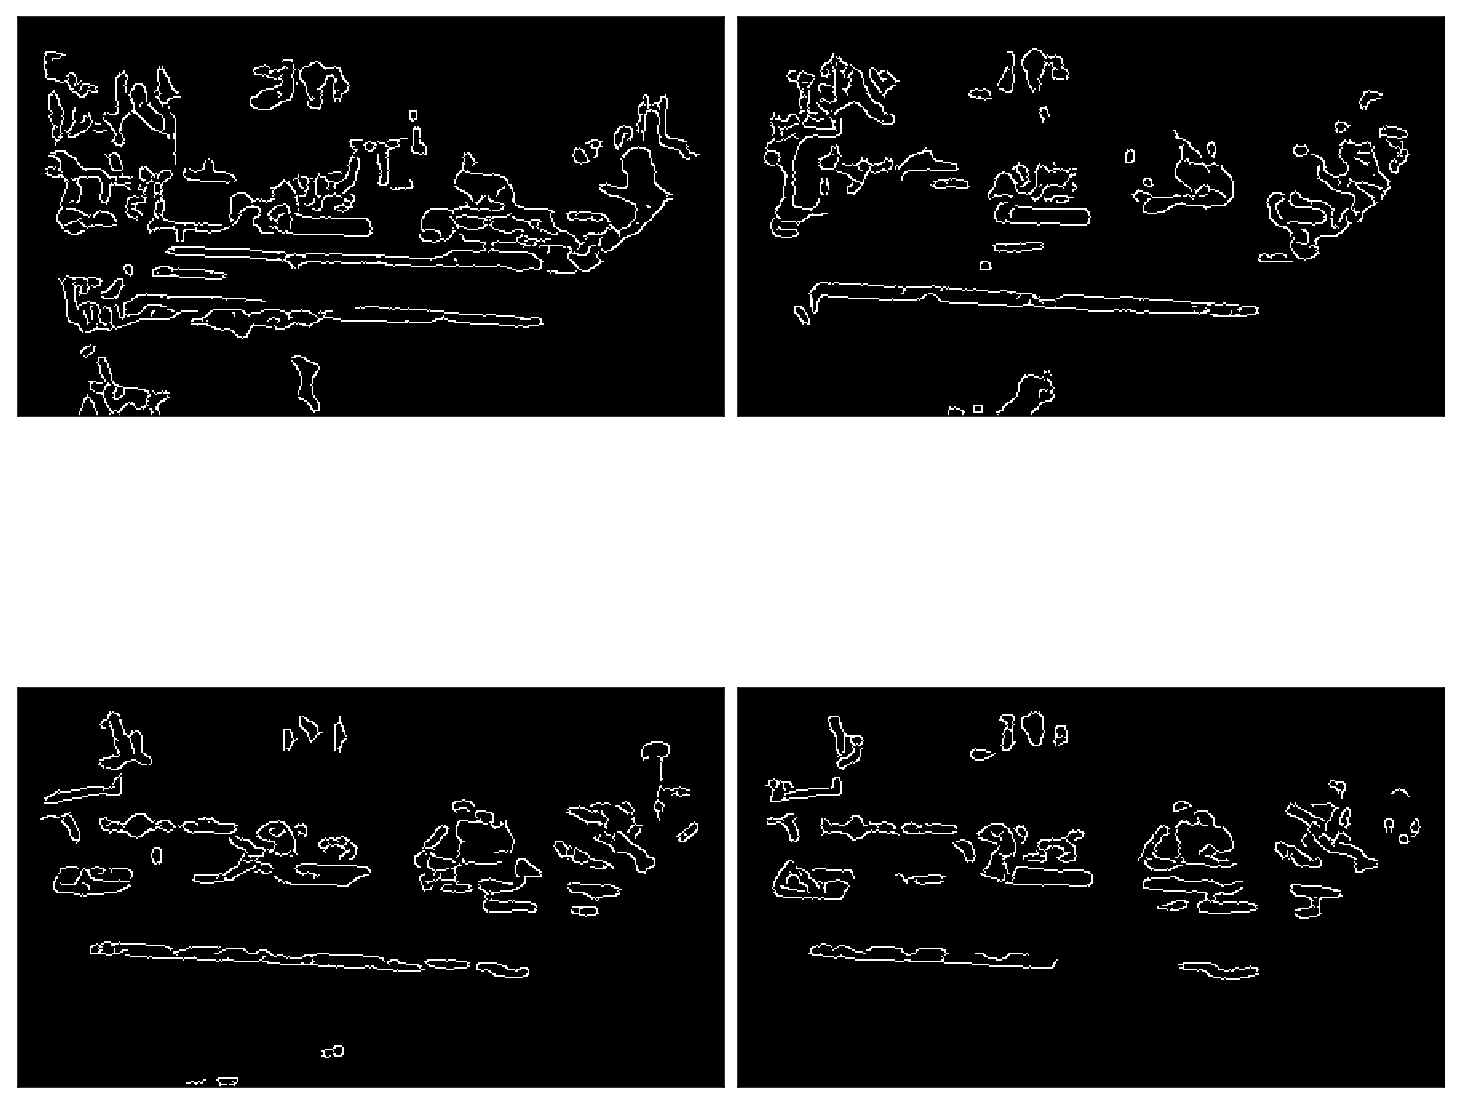

In [103]:
test_images = test_images[0:4]
#test_images
#show_images(test_images)
yellow_images = list(map(select_yellow, test_images))
#show_images(yellow_images)


gray_images = list(map(convert_gray_scale, yellow_images))

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

def detect_edges(image, low_threshold=20, high_threshold= 80):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))

show_images(blurred_images)
show_images(edge_images)


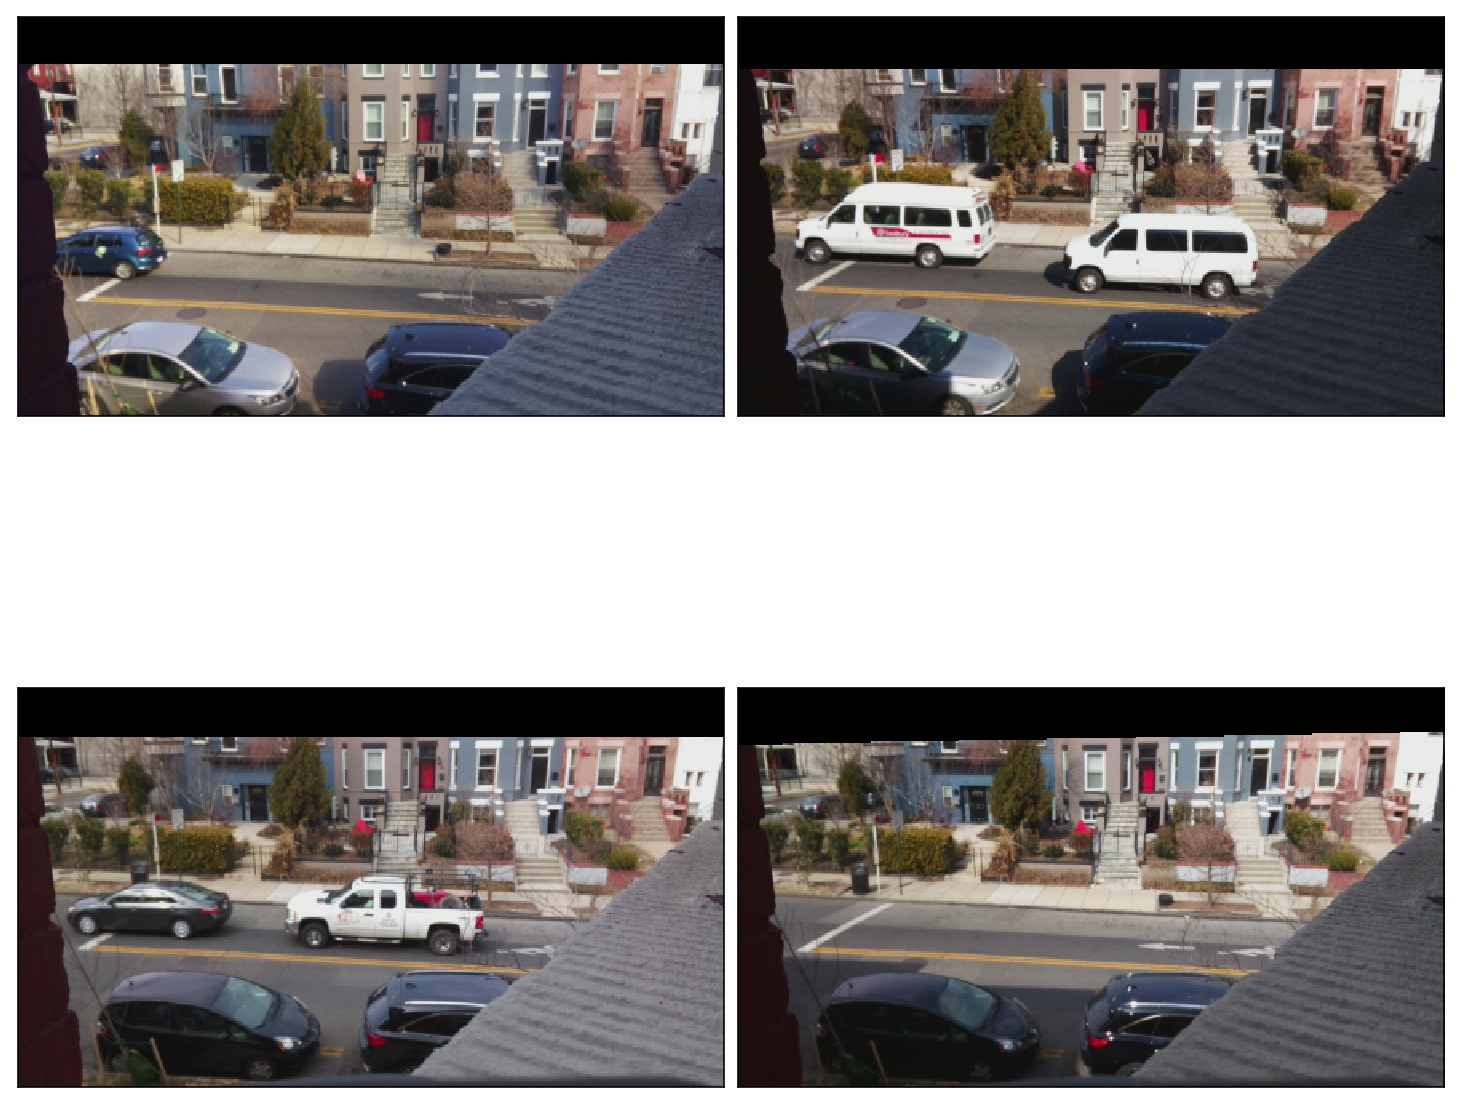

In [104]:



roi_images = list(map(select_region, edge_images))

list_of_lines = list(map(hough_lines, roi_images))

line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))

long_line_list=[]
for line in list_of_lines:
    long_line_list.append(get_slope_intercept_longest(line))
    
#Optional 
line_images = []
long_line_points = []
for image, lines in zip(test_images, long_line_list):
    long_line = make_line_points(image, lines)
    long_line_points.append(long_line)
    line_images.append(draw_line(image, long_line))
    
aoi_images = list(map(select_aoi, test_images,long_line_list))

show_images(aoi_images)
    
    

In [84]:
list_of_lines

[array([[[ 36, 129, 383, 129]],
 
        [[180, 247, 390, 126]],
 
        [[187, 130, 381, 130]],
 
        [[276, 178, 325, 182]],
 
        [[182, 247, 389, 127]],
 
        [[276, 184, 318, 187]],
 
        [[ 28, 128, 389, 128]],
 
        [[172, 239, 362, 138]]], dtype=int32), array([[[296, 133, 361, 137]],
 
        [[ 25, 128, 377, 128]],
 
        [[ 63, 127, 361, 142]],
 
        [[ 23, 127, 376, 127]],
 
        [[291, 136, 374, 130]],
 
        [[ 66, 126, 362, 141]]], dtype=int32), array([[[ 27, 130, 321, 135]],
 
        [[259, 126, 376, 130]],
 
        [[ 22, 125, 361, 143]],
 
        [[280, 128, 370, 125]],
 
        [[ 42, 125, 357, 130]],
 
        [[271, 136, 368, 131]],
 
        [[ 30, 125, 363, 142]],
 
        [[ 23, 128, 363, 140]]], dtype=int32), array([[[  4, 137, 259, 146]],
 
        [[  4, 130, 257, 148]],
 
        [[ 77, 127, 271, 144]],
 
        [[  7, 139, 255, 152]],
 
        [[ 19, 125, 257, 150]],
 
        [[106, 165, 161, 170]],
 
        [[ 7